# MLP (neural network) examples


In [1]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch import nn
import time

In [2]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch

Author: Wei Li

Last updated: 2023-12-28 21:02:47

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy: 1.21.5
torch: 1.12.1



In [3]:
# From local helper files
from utils_evaluation import set_all_seeds, set_deterministic, evaluate_epoch_loss, evaluate_epoch_metrics
from utils_plotting import plot_accuracy, plot_loss

This is data on a job training program (the treatment) that was intended to raise
future earnings (the outcome). The income in $\$1000$ in the year of 1978. The data combines the original experimental data (445 observations) and additional control observations from PSID data, totalling $2675$ observations.


\begin{align*}
%\begin{array}{ll}
\hline \text { Variable } & \text { Description } \\
\hline \text { age } & \text { Age in years } \\
\text { educ } & \text { Years of education } \\
\text { black } & 1=\text { Black; } 0 \text { otherwise } \\
\text { hisp } & 1=\text { Hispanic; } 0 \text { otherwise } \\
\text { married } & 1=\text { married; } 0 \text { otherwise } \\
\text { nodegr } & 1=\text { no degree; } 0 \text { otherwise } \\
\text { re74 } & 1974 \text { income}\\
\text { re75 } & 1975 \text { income}  \\
\text { re78 } & 1978 \text { income} \\
\text { treat } & 1=\text { received treatment; } 0 \text { otherwise } \\
\hline
%\end{array}
\end{align*}


In [4]:
raw_data_all = pd.read_csv('../data/psid_LDW_merged.csv').drop(["u74", "u75"], axis=1)

In [5]:
raw_data_all.head()

,T,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [6]:
# stats for treatment
print(raw_data_all.describe())
print()

np.bincount(raw_data_all['T']), np.bincount(raw_data_all["re78"] > 0)
# counts of 0/1
# (array([2490,  185]), array([ 331, 2344]))
# about 7% enrolled in the training program
# about 13% unemployed in 1978

                 T          age         educ        black         hisp  \
count  2675.000000  2675.000000  2675.000000  2675.000000  2675.000000   
mean      0.069159    34.225794    11.994393     0.291589     0.034393   
std       0.253772    10.499842     3.053556     0.454579     0.182269   
min       0.000000    17.000000     0.000000     0.000000     0.000000   
25%       0.000000    25.000000    10.000000     0.000000     0.000000   
50%       0.000000    32.000000    12.000000     0.000000     0.000000   
75%       0.000000    43.500000    14.000000     1.000000     0.000000   
max       1.000000    55.000000    17.000000     1.000000     1.000000   

           married       nodegr           re74           re75           re78  
count  2675.000000  2675.000000    2675.000000    2675.000000    2675.000000  
mean      0.819439     0.333084   18230.003096   17850.893766   20502.375641  
std       0.384726     0.471404   13722.251526   13877.777180   15632.519749  
min       0.00000

(array([2490,  185]), array([ 331, 2344]))

### Task 1: predict re78 using all other variables

In [7]:
##########################
### SETTINGS
##########################
RANDOM_SEED = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)
set_deterministic()

##########################
### DATASET
##########################

#Split data into training features and labels
X, y = raw_data_all.loc[:, raw_data_all.columns != 're78'], raw_data_all['re78']

# split data into train and test sets using train_test_split()

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED, stratify=raw_data_all['T'])
# stratify is used to balance data based on the proportion of treatment

In [8]:
np.bincount(x_train['T']), np.bincount(x_test['T'])

(array([1743,  129]), array([747,  56]))

In [9]:
# scaling of the features/predictors are essential for most algorithms (with the exception of tree-based methods)

stdscaler = StandardScaler()
x_train_std = stdscaler.fit_transform(x_train)
x_test_std = stdscaler.transform(x_test)

In [10]:
# define our own Dataset class

class MyDataset(Dataset):
    # constructor
    # In this case it contains the data
    def __init__(self, x, y):
        xs = torch.tensor(np.array(x)).to(torch.float)
        ys = torch.tensor(np.array(y)).to(torch.float)
        self.xs = xs
        self.ys = ys
    
    # len()
    # returns the length of the dataset
    def __len__(self):
        return self.xs.shape[0]  #len(self.ys)
    
    #[]
    # returns the item at index i
    # this tells how a single data point is loaded
    def __getitem__(self, i):
        return self.xs[i,], self.ys[i]

In [11]:
# Create instances of MyDataset class

train_data = MyDataset(x_train_std, y_train)
# train_data[0,]
test_data = MyDataset(x_test_std, y_test)

In [12]:
# Create instances of dataloader 

torch.manual_seed(1)
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=False)

# for epoch in range(2):
#     print(f'epoch {epoch+1}')
#     for idx, batch in enumerate(train_loader):
#         print(f'batch {idx}:', 'x:', batch[0], '\n y:', batch[1])

In [13]:
print("No. of train examples  : ", train_data.__len__())
print("Shape of train input : ", train_data[0][0].shape)
print("Shape of train output : ", train_data[0][1].shape) # scalar
print("No. of test examples  : ", test_data.__len__())
print("Train batches        : ", train_loader.__len__())
print("Test batches        : ", test_loader.__len__())

No. of train examples  :  1872
Shape of train input :  torch.Size([9])
Shape of train output :  torch.Size([])
No. of test examples  :  803
Train batches        :  468
Test batches        :  201


In [14]:
# Create model class

class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.05)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        return out

        

In [15]:
NUM_EPOCHS = 50
LR = 1e-4

# instantiate model class
input_dim=9 
hidden_dim=100
output_dim=1
model = FNN(input_dim, hidden_dim, output_dim)

# instantiate loss
criterion = nn.MSELoss()

# instantiate optimizer class
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LR)


In [16]:
# Train the model
loss = None 

start_time = time.time()
minibatch_loss_list, avg_loss_list, train_loss_list, test_loss_list = [], [], [], []
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        # ## FORWARD AND BACK PROP
        y_pred = model(features)
        loss = criterion(y_pred, targets)
        optimizer.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 200:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss:.4f}')

    model.eval()
    with torch.no_grad():  # save memory during inference

        ### logging for running average of loss over all traversed minibatches
        # avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list)) 
        # or the average over most recent minibatches in last epoch
        avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list[-len(train_loader):])) 
        avg_loss_list.append(avg_loss)

        ### Compute overall (average) loss
        train_loss = evaluate_epoch_loss(model, train_loader, device=device, criterion = nn.MSELoss())[1]
        test_loss = evaluate_epoch_loss(model, test_loader, device=device,criterion = nn.MSELoss())[1]
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                f'| Train: {train_loss:.2f} '
                f'| Test: {test_loss:.2f}')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

print()
test_loss = evaluate_epoch_loss(model, test_loader, device=device,criterion = nn.MSELoss())[1]
print(f'Test MSE {test_loss :.2f}')

Epoch: 001/050 | Batch 0000/0468 | Loss: 1476165632.0000
Epoch: 001/050 | Batch 0200/0468 | Loss: 710179520.0000


/Users/wli169/miniconda3/envs/py38torch_arm/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001/050 | Batch 0400/0468 | Loss: 495135072.0000
Epoch: 001/050 | Train: 680363668.75 | Test: 622489711.34
Time elapsed: 0.01 min
Epoch: 002/050 | Batch 0000/0468 | Loss: 394596384.0000


/Users/wli169/miniconda3/envs/py38torch_arm/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 002/050 | Batch 0200/0468 | Loss: 987050944.0000
Epoch: 002/050 | Batch 0400/0468 | Loss: 764289472.0000
Epoch: 002/050 | Train: 654730723.30 | Test: 597871095.10
Time elapsed: 0.01 min
Epoch: 003/050 | Batch 0000/0468 | Loss: 845149632.0000
Epoch: 003/050 | Batch 0200/0468 | Loss: 861845248.0000
Epoch: 003/050 | Batch 0400/0468 | Loss: 198905200.0000
Epoch: 003/050 | Train: 574776206.40 | Test: 524188217.50
Time elapsed: 0.02 min
Epoch: 004/050 | Batch 0000/0468 | Loss: 128116448.0000
Epoch: 004/050 | Batch 0200/0468 | Loss: 271042816.0000
Epoch: 004/050 | Batch 0400/0468 | Loss: 443042304.0000
Epoch: 004/050 | Train: 441429653.76 | Test: 401083182.22
Time elapsed: 0.02 min
Epoch: 005/050 | Batch 0000/0468 | Loss: 242227840.0000
Epoch: 005/050 | Batch 0200/0468 | Loss: 198211728.0000
Epoch: 005/050 | Batch 0400/0468 | Loss: 59432692.0000
Epoch: 005/050 | Train: 321847505.73 | Test: 292062628.77
Time elapsed: 0.03 min
Epoch: 006/050 | Batch 0000/0468 | Loss: 80499488.0000
Epoch:

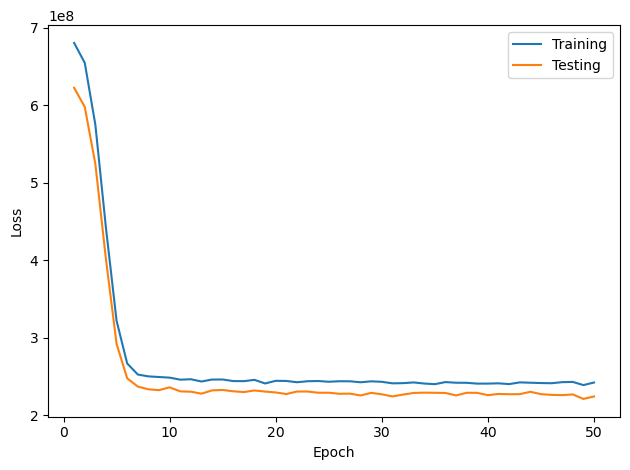

In [17]:
# Evaluation

plot_loss(train_loss_list=train_loss_list,
              valid_loss_list=test_loss_list,
              results_dir=None)
plt.show()
#plt.savefig('reg_out.png')

### Task 2: predict if re78>0 using all other variables

In [18]:
# Split data into training features and labels
X, y = raw_data_all.loc[:, raw_data_all.columns != 're78'], (raw_data_all['re78']>0).astype(int)
# y= re78 is binary
# split data into train and test sets using train_test_split()

seed = 2022
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=pd.concat([y, X['T']], axis=1))
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

In [19]:
np.bincount(y_train), np.bincount(y_test), np.bincount(x_train['T']), np.bincount(x_test['T'])

(array([ 232, 1640]),
 array([ 99, 704]),
 array([1742,  130]),
 array([748,  55]))

In [20]:
# scaling of the features/predictors are essential for most algorithms (with the exception of tree-based methods)

stdscaler = StandardScaler()
x_train_std = stdscaler.fit_transform(x_train)
x_test_std = stdscaler.transform(x_test)


In [21]:
# define our own Dataset class

class MyDataset(Dataset):
    # constructor
    # In this case it contains the data
    def __init__(self, x, y):
        xs = torch.tensor(np.array(x)).to(torch.float)
        ys = torch.tensor(np.array(y)).to(torch.long)
        self.xs = xs
        self.ys = ys
    
    #len()
    # returns the length of the dataset
    def __len__(self):
        return self.xs.shape[0]  #len(self.ys)
    
    #[]
    # returns the item at index i
    # this tells how a single data point is loaded
    def __getitem__(self, i):
        return self.xs[i,], self.ys[i]

In [22]:
# Create instances of MyDataset class

train_data = MyDataset(x_train_std, y_train)
# train_data[0,]
test_data = MyDataset(x_test_std, y_test)

# Create instances of dataloader 

torch.manual_seed(1)
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=False)

In [23]:
import torch.nn.functional as F

class FNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.fc3(out)  # Output logits directly
        return out

# we shall use nn.CrossEntropyLoss in classification tasks. This loss function internally applies 
# the softmax operation as part of the loss computation, making it more numerically stable than 
# applying softmax in the model's forward pass and then using a loss function 
# like nn.NLLLoss that expects log probabilities.    


In [24]:
# instantiate model class

input_dim=9 
hidden_dim=200
output_dim=2

model = FNN2(input_dim, hidden_dim, output_dim)

# instantiate loss class

criterion = nn.CrossEntropyLoss()

# instantiate optimizer class

learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)


In [25]:
# Train the model
loss = None 

start_time = time.time()
minibatch_loss_list, avg_loss_list,train_loss_list, test_loss_list, train_acc_list, test_acc_list = [],[], [], [], [], []
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        # ## FORWARD AND BACK PROP
        y_pred = model(features)
        loss = criterion(y_pred, targets)
        optimizer.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 200:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss:.4f}')
            
    model.eval()
    with torch.no_grad():  # save memory during inference
        ### logging for running average of loss over all traversed minibatches
        # avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list)) 
        # or the average over most recent minibatches in last epoch
        avg_loss = torch.mean(torch.FloatTensor(minibatch_loss_list[-len(train_loader):])) 
        avg_loss_list.append(avg_loss)

        train_loss = evaluate_epoch_loss(model, train_loader, device=device, criterion = nn.CrossEntropyLoss())[1]
        test_loss = evaluate_epoch_loss(model, test_loader, device=device,criterion = nn.CrossEntropyLoss())[1]

        train_acc = evaluate_epoch_metrics(model, train_loader, device=device)
        test_acc = evaluate_epoch_metrics(model, test_loader, device=device)

        # Print train and test loss along with accuracy
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
            f'| Train Loss: {train_loss:.4f} '
            f'| Test Loss: {test_loss:.4f} '
            f'| Train Acc: {train_acc:.2f}% '
            f'| Test Acc: {test_acc:.2f}% ')
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

test_acc = evaluate_epoch_metrics(model, test_loader, device=device)
print(f'Test accuracy {test_acc :.2f}')

Epoch: 001/050 | Batch 0000/0468 | Loss: 5.4287
Epoch: 001/050 | Batch 0200/0468 | Loss: 0.9944
Epoch: 001/050 | Batch 0400/0468 | Loss: 0.1408
Epoch: 001/050 | Train Loss: 0.3746 | Test Loss: 0.3804 | Train Acc: 87.61% | Test Acc: 87.67% 
Time elapsed: 0.01 min
Epoch: 002/050 | Batch 0000/0468 | Loss: 0.4618
Epoch: 002/050 | Batch 0200/0468 | Loss: 0.2466
Epoch: 002/050 | Batch 0400/0468 | Loss: 1.0655
Epoch: 002/050 | Train Loss: 0.3023 | Test Loss: 0.3092 | Train Acc: 87.61% | Test Acc: 87.67% 
Time elapsed: 0.02 min
Epoch: 003/050 | Batch 0000/0468 | Loss: 0.5767
Epoch: 003/050 | Batch 0200/0468 | Loss: 0.2599
Epoch: 003/050 | Batch 0400/0468 | Loss: 0.0799
Epoch: 003/050 | Train Loss: 0.2821 | Test Loss: 0.2886 | Train Acc: 89.58% | Test Acc: 89.17% 
Time elapsed: 0.03 min
Epoch: 004/050 | Batch 0000/0468 | Loss: 0.0688
Epoch: 004/050 | Batch 0200/0468 | Loss: 0.1098
Epoch: 004/050 | Batch 0400/0468 | Loss: 0.0357
Epoch: 004/050 | Train Loss: 0.2738 | Test Loss: 0.2792 | Train Acc

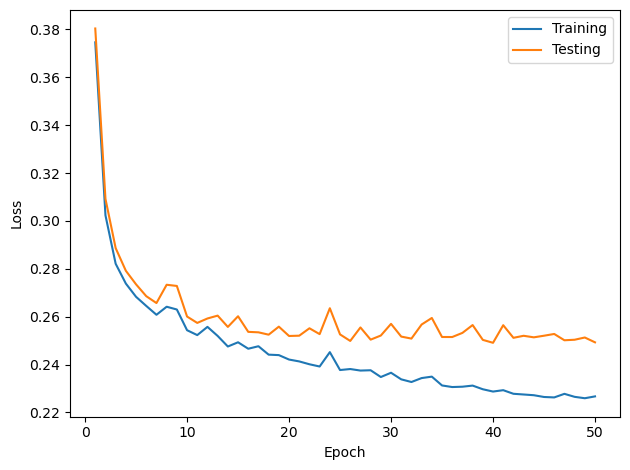

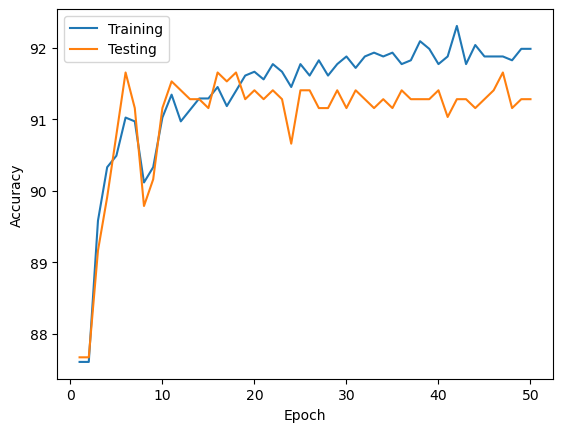

In [26]:
# Evaluation
plot_loss(train_loss_list=train_loss_list,
              valid_loss_list=test_loss_list,
              results_dir=None)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=test_acc_list,
              results_dir=None)
plt.show()